# Поиск выбросов (outliers)

In [21]:
import numpy as np
import pandas as pd
from math import radians, sin, cos, asin, sqrt
%matplotlib inline

vis_data = pd.read_csv("train.csv", 
                       encoding = 'ISO-8859-1', 
                       low_memory = False)
vis_data = vis_data.drop(['violation_zip_code', 'clean_up_cost'], axis=1)
latlons = pd.read_csv("latlons.csv.xls")
vis_data = pd.concat([vis_data, latlons], axis=1)

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return c * earth_radius

vis_data['distance'] = vis_data.apply(lambda row: 
                                      haversine(lon1 = -83.045753, 
                                                lat1 = 42.331429,
                                                lon2 = row['lon'], 
                                                lat2 = row['lat']), 
                                      axis=1)

Рассмотрим 4 способа устранить выбросы в данных
- поиск и удалению по порогу (ручной EDA)
- поиск по отклонению ( z score )
- межквартильное расстояния (IQR)
- поиск по расспростронению 
- DBSCAN

## 1. Поиск и удаление по порогу (threshold)

- Часто оказывается так, что при погружении в предметную область вы начинаете понимать, какие значения данные признаки могут принимать, а какие - не могут. 
- Например, если нужно заплатить штраф, полезно будет проверить, нет ли в выборке значений штрафов, меньших, чем `0`:

In [22]:
np.sum(vis_data.fine_amount < 0)

0

- Кроме этого, интересно посмотреть максимальное значение штрафа:

In [23]:
max_fine = np.max(vis_data.fine_amount)
max_fine

10000.0

- И сколько раз и как часто такой штраф встречается в данных:

In [24]:
max_fine_count = np.sum(vis_data.fine_amount == max_fine)
max_fine_count, max_fine_count/vis_data.shape[0]

(357, 0.0014262542647799094)

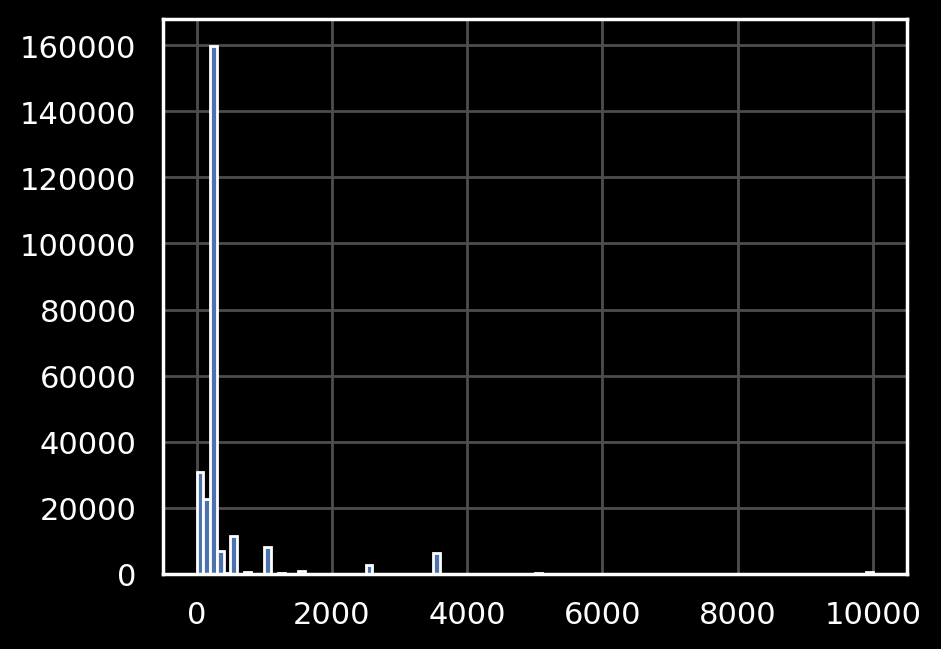

In [25]:
vis_data.fine_amount.hist(bins=100);

- Очень большое количество данных **сосредоточено около 0**
- Посмотрим, сколько значений штрафов в выборке равно 0:

In [26]:
vis_data[vis_data.fine_amount == 0].shape[0]

195

**Выброс @ fine_amount=0**

- Возможно, те значения, где размер штрафа равен 0, являются выбросами, если инспектор забыл добавить размер штрафа или ошибся при вводе
- В таком случае эти значения следует убрать из выборки. В то же время, сложно однозначно сделать такое решение, не зная всей информации о данных

Теперь посмотрим на данные поближе:

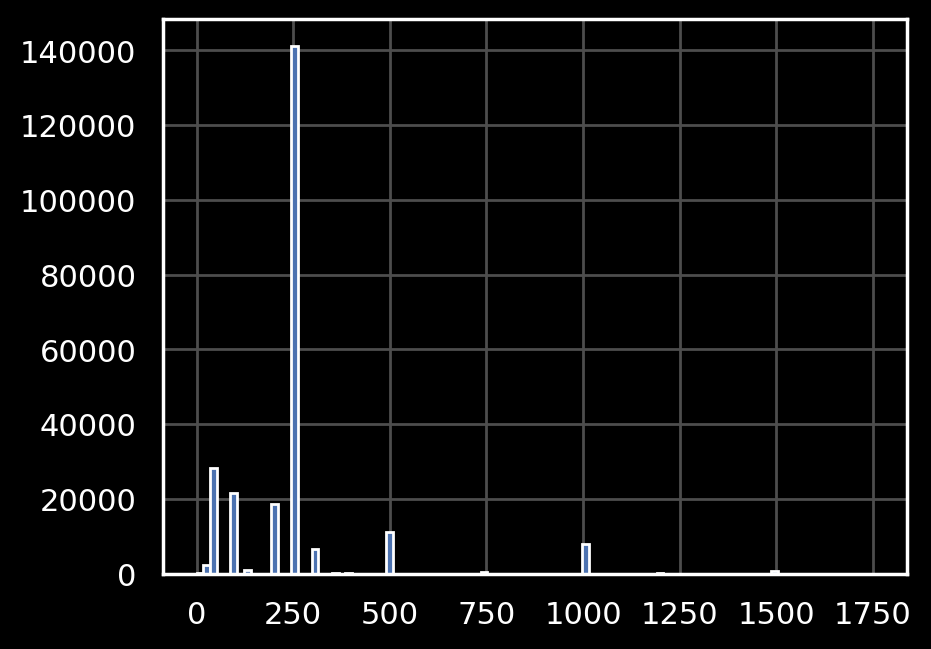

In [27]:
vis_data.fine_amount[vis_data.fine_amount < 2000].hist(bins=100);

**Вроде болше нету выбросов**

- Непохоже, что здесь есть выбросы (кроме нулевых штрафов), но можно категоризировать данные, заменив все значения больше 2000 на переменную `>2000` и сделав все остальные **значения категориальными**

## 2. Поиск по отклонению (z-score)
[Источник](http://colingorrie.github.io/outlier-detection.html)

- Статистический подход
- Есть еще один способ поиска выбросов, **не требующий настолько же пристального взгляда на данные** что и предыдущий метод
- Он основан на поиске значения, на которое отклоняется данная точка от среднего

Делается это с помощью `z-score`
- то есть, **расстояния (измеряемого в количестве стандартных отклонений) от среднего значения точек**

Для начала посмотрим на распределение данных для признака `distance`, который мы посчитали ранее:

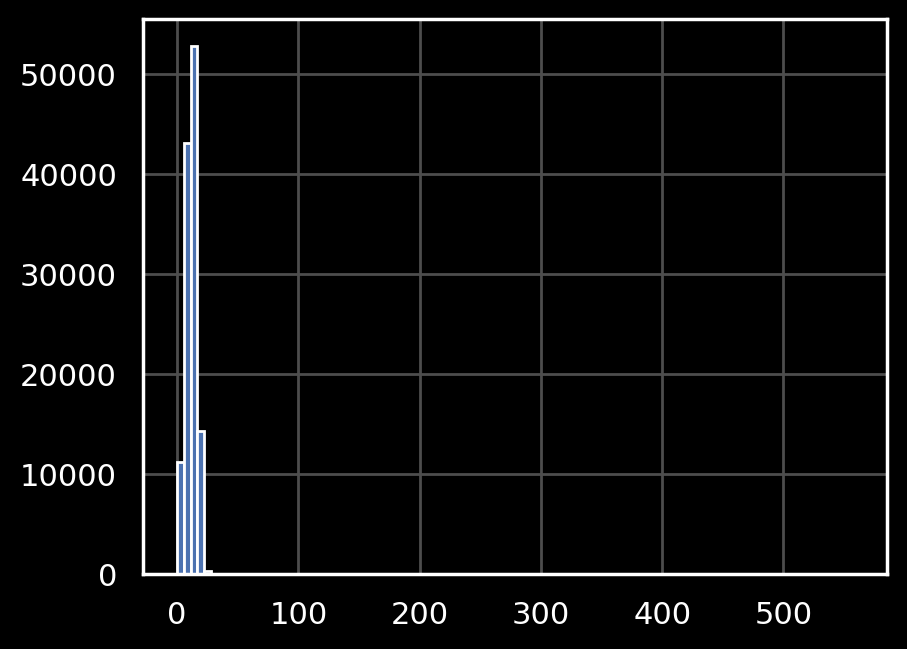

In [28]:
import warnings
vis_data['distance'].hist(bins=100)

Попытаемся "на глаз" определить порог, после которого мы считаем выбросы. Применим этот порог и посмотрим на количество "выбросов":

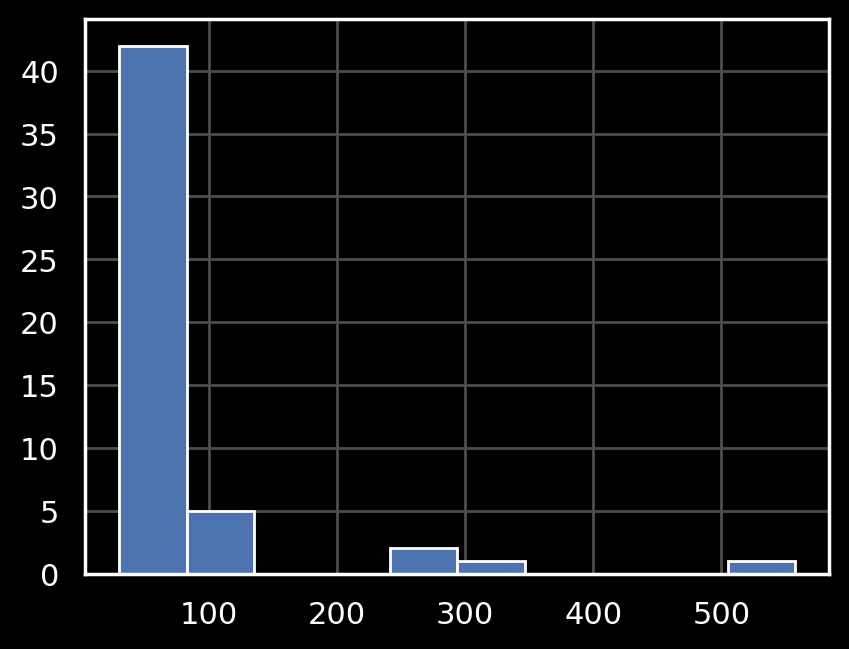

In [29]:
vis_data.distance[vis_data.distance > 30].hist();

In [30]:
# поиск по отклонению
def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    o = outliers_z_score(vis_data.distance)
    
print(o)
print(len(o),'outliers')

[  1007   2879   4170   6726   7861   8831  12314  16177  16820  17178
  17976  20861  21610  22131  22516  23047  23333  24527  30538  31974
  33767  41553  46820  48931  49435  53829  58451  59437  59619  62611
  63120  63649  66380  67084  68221  73455  74397  74614  77930  80950
  83770  84852  89127  89646  89680  90244  90608  92528  93207 102023
 104962 107372 109419 115726 121517]
55 outliers


- Значение по умолчанию для функции поиска выбросов равно `3`. 
- Это означает, что мы считаем выбросами все, что находится на расстоянии больше 3 стандартных отклонений от среднего. 
- Если мы подвигаем этот параметр в большую или меньшую сторону, мы найдем меньше или больше выбросов.

## 3. IQR (interquartile range, межквартильное расстояние)

- Статистический подход
- Один из способов - **использовать перцентили** (в данном случае **квартили**) для определения, где находятся выбросы

Для начала, посмотрим на `boxplot` для признака `distance`

- Данный вид **графика делит данные на 4 части**
- Та часть данных, **которая отделена слева** и **справа двумя вертикальными линиями** (находится внутри коробки) содержит 50% данных
- Так как **левая линия обозначает первый квартиль (25-й перцентиль)**
- а **правая линия обозначает третий квартиль (75-й перцентиль)** 
- Большой вертикальной линией выделена **медиана**

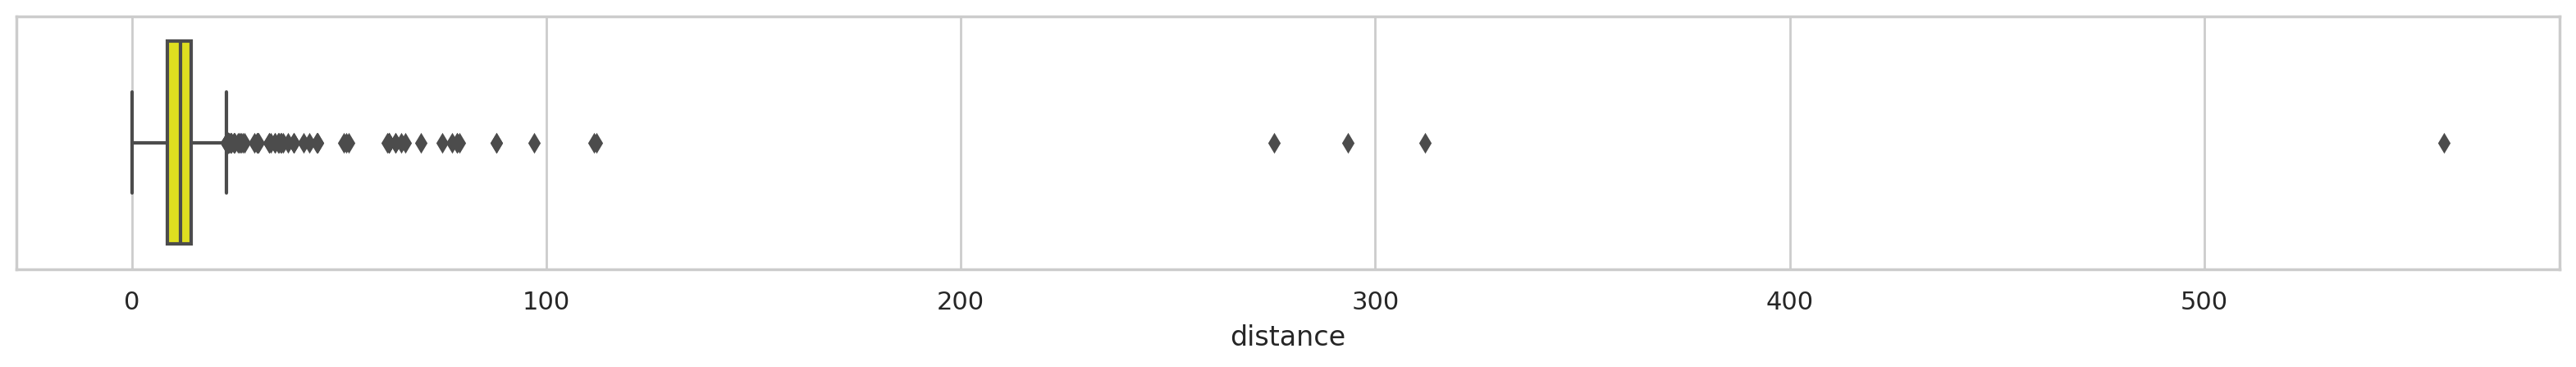

In [55]:
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns

sns.set(rc={'figure.figsize':(20,2)},style='whitegrid')

sns.boxplot(x=vis_data.distance, color='yellow');

- Метод **межквартильного расстояния** выделяет как выбросы все значения, **находящиеся за пределами коробки**
- Посмотрим, сколько выбросов он найдет:

In [57]:
def outliers_iqr(ys):
    q1, q3 = np.percentile(ys, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

# Данный метод чувствителен к пропускам, поэтому избавимся от них:
o = outliers_iqr(vis_data.distance.dropna())
print(o)
print(len(o), 'outliers')

[  1007   1674   2280   2458   2516   2879   3024   4169   4336   5731
   6725   7860   8830  10033  11646  12312  15355  16029  16175  16818
  17176  17939  17973  19754  20858  21607  22128  22513  23044  23330
  24265  24524  25381  27381  29498  29505  30535  31689  31890  31971
  32718  32900  33764  34469  35959  38262  40806  41500  41549  45143
  46190  46612  46816  48542  48927  49431  49888  52537  53825  53885
  58252  58446  59432  59614  60341  62606  63115  63644  63858  64748
  66375  67079  67739  68216  69121  69426  70314  73450  73473  73850
  74075  74228  74392  74609  75262  76395  76610  76939  77924  77997
  78375  80921  80944  83764  84498  84846  86723  87761  88894  89121
  89640  89674  90238  90602  92411  92522  93201  93504  94805  96286
  98008 100461 100929 101449 102016 102686 104902 104955 107365 108082
 108568 109412 110607 110799 110850 111594 113123 114873 115719 115740
 118052 118308 119056 121510]
134 outliers


## 4. Поиск по распределению
[Источник](http://aqibsaeed.github.io/2016-07-17-anomaly-detection/)

- Еще один способ - **построить нормальное распределение поверх данных**
- посчитать вероятность находиться в данном распределении для каждого значения
- **Самые невероятные значения будем считать выбросами**

In [62]:
from scipy.stats import norm

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def get_gaussian(mu, sigma):
    distribution = norm(mu, sigma)
    return distribution

def get_probs(distribution, dataset):
    return distribution.pdf(dataset)

In [63]:
# строим нормальное распределение 
mu, sigma = estimate_gaussian(vis_data.distance.dropna())
distribution = get_gaussian(mu, sigma)

# подсчитаем вероятность появления данной точки 
probabilities = get_probs(distribution, vis_data.distance.dropna())

- Мы построили **нормальное распределение** на предоставленных данных
- Посчитали вероятность появления данной точки при данном распределении для каждого значения. 
- Теперь выберем разумное значение вероятности, ниже которой будем считать точку выбросом. Например, `0.014`:

In [64]:
o_1 = np.where(probabilities < 0.014)[0]
print(o_1)
print(len(o_1))

[  1007   2879   4169   6725   7860   8830  12312  16175  16818  17176
  17973  20858  21607  22128  22513  23044  23330  24524  30535  31971
  33764  41549  46816  48927  49431  53825  58446  59432  59614  62606
  63115  63644  63858  66375  67079  68216  73450  74228  74392  74609
  77924  80944  83764  84846  89121  89640  89674  90238  90602  92522
  93201 102016 104955 107365 109412 114873 115719 121510]
58


## 5. DBSCAN

- Алгоритм кластеризации `DBSCAN` определяет группы (кластеры) объектов.
- Его особенностью является то, что кроме самих кластеров он хорошо находит отдельно стоящие элементы, "шум". 
- Применим его для нахождения выбросов

`DBSCAN` работает очень медленно, поэтому мы возьмем не все данные:

In [38]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [39]:
print(vis_data.shape)

normalized_dist = np.random.choice(vis_data['distance'].dropna().values, 10000)[:,None]
print(normalized_dist.shape)

(250306, 36)
(10000, 1)


In [65]:
model = DBSCAN(eps=0.5, min_samples=10)
model.fit(normalized_dist)
outliers = np.where(model.labels_ == -1)[0]
print(outliers)
print(len(outliers))

[ 944 3708 4455 8187 8472 9242]
6


## Проблемы с выбросами

Несмотря на то, что выбросы "портят" общую картину и заставляют статистики в данных (например, среднее) выглядеть неправильно, иногда они очень важны:

 - Если мы занимаемся поиском аномалий (Anomaly Detection), выбросы являются нашими зависимыми переменными, которые необходимо найти, а не значениями, которые нужно выбросить. Поиск аномалий выходит за рамки курса
 - Как можно было понять из методов выше, нет однозначного способа понять, что перед нами выброс. Разные методы возвращают разные точки в качестве выбросов, и эти точки пересекаются лишь частично. Кроме этого, разные параметры дают разные результаты и эти параметры необходимо крутить руками. Из-за этого найденные выбросы является крайне субъективным результатом